In [1]:
from diffusers import AutoencoderKL
import numpy as np
import torch

/home/admin/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-28 17:38:02.207574: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-28 17:38:02.249643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 17:38:02.964600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorR

In [2]:
# PATHS
WORKING_DIR = "/home/admin/FEUP-Synthesizing-Audio-from-Textual-Input/data/working"
SPECTROGRAM_DIR = WORKING_DIR + "/spectrograms"

# MODELS
VAE_MODEL = "cvssp/audioldm"
VAE_MODEL_SUBFOLDER = "vae"

# DEVICE
DEVICE = "cuda"

# DATAset
SAMPLE_RATE = 48_000
MAX_INPUT_SIZE = 65_536

# TRAINING
BATCH_SIZE = 4

# GAN
# Number of channels in the training images. For color images this is 3
CHANNELS_DATA = 8
CHANNELS_LATENT = 8

# Checkpoint
CHECKPOINT_INTERVAL = 10000
CHECKPOINT_PATH = "checkpoint.pth"

In [3]:
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path=VAE_MODEL, subfolder=VAE_MODEL_SUBFOLDER).to(DEVICE)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Create spectrograms

In [12]:
import torchaudio
import os
import pandas as pd
from tqdm import tqdm
from scipy.io import wavfile

In [13]:
if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)
    
if not os.path.exists(SPECTROGRAM_DIR):
    os.mkdir(SPECTROGRAM_DIR)

In [14]:
def create_spectrograms(input_size=int(MAX_INPUT_SIZE/2)):
    """
    Create Mel spectrograms from audio files in the INPUT_DIR directory and save them to the SPECTROGRAM_DIR directory.

    Args:
        input_size: The desired length of the audio files (in number of samples). Default value is MAX_INPUT_SIZE/2.

    Returns:
        None
    """

    # Iterate over all folders in INPUT_DIR
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if "folder" is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        # Iterate over all files in the folder
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            file_path = os.path.join(INPUT_DIR, folder, file)
            # Skip files that are not WAV files
            if not file_path.endswith('.wav'):
                continue

            # Load the audio file
            sample_rate, samples = wavfile.read(file_path)

            # Pad the audio file if it's smaller than input_size
            if samples.shape[0] < input_size:
                # Calculate the amount of padding needed
                pad_size = input_size - samples.shape[0]
                # Divide the padding equally between the left and right sides of the audio file
                left_pad = pad_size // 2
                right_pad = pad_size - left_pad
                # Pad the audio file with zeros
                samples = np.pad(samples, (left_pad, right_pad), mode='constant')

            # Crop the audio file at the center if it's larger than input_size
            elif samples.shape[0] > input_size:
                # Calculate the start and end positions for the crop
                start = (samples.shape[0] - input_size) // 2
                end = start + input_size
                # Crop the audio file
                samples = samples[start:end]

            # Convert the audio file to a float tensor
            samples = torch.from_numpy(samples).float()
                
            # Create the spectrogram using MelSpectrogram transform
            spectrogram = torchaudio.transforms.MelSpectrogram(
                n_fft=2048, hop_length=128, power=1)(samples)

            # Save the spectrogram as a Numpy array
            label = file.split("_")[0]
            label_dir = os.path.join(SPECTROGRAM_DIR, label)
            os.makedirs(label_dir, exist_ok=True)
            np.save(os.path.join(label_dir, file), spectrogram.numpy())
            
def create_csv_info():
    # initialize the dataset
    dataset = pd.DataFrame(columns=["file", "label", "speaker"])

    # loop over the directories in SPECTROGRAM_DIR
    for number in tqdm(os.listdir(SPECTROGRAM_DIR)):
        # check if "number" is a folder
        # "number" should be a folder with all the recordings spectrgrams of the given
        # number, the label (number) is the name of the folder
        if not os.path.isdir(os.path.join(SPECTROGRAM_DIR, number)):
            continue

        # loop over the files in the current directory
        for file in os.listdir(os.path.join(SPECTROGRAM_DIR, number)):
            # an example file is 8_06_38.wav.npy
            # extract the speaker ID from the file name
            speaker = file.split("_")[1]
            # assign the current directory name to the label variable
            label = number
            # construct the file path by joining the directory name and file name
            file_path = os.path.join(number, file)

            # append a new row to the dataset DataFrame with the file path, label, and speaker values
            new_row = pd.DataFrame([{
                "file": file_path,     
                "label": label,
                "speaker": speaker
            }])
            dataset = pd.concat([dataset, new_row], ignore_index=True)

    # write dataset as csv
    dataset.to_csv(os.path.join(WORKING_DIR, "dataset.csv"), index=False)

In [20]:
#if not os.path.exists(SPECTROGRAM_DIR):
create_spectrograms()

100%|██████████| 61/61 [05:51<00:00,  5.76s/it]


In [26]:
#if not os.path.exists('/kaggle/working/dataset.csv'):
create_csv_info()

100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


In [27]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

In [28]:
import matplotlib.pyplot as plt

class Spectrogram():
    # this defines one spectrogram sample
    def __init__(self, data, speaker, label):
        self.data = data
        self.speaker = speaker
        self.label = label

    def display(self):
        """
        Display the spectrogram using matplotlib.

        This method plots the spectrogram data as an image with a colormap. It sets the title of the plot to
        "Speaker {speaker}, Label {label}", where {speaker} and {label} are replaced with the values of the
        speaker and label attributes of the Spectrogram object. It sets the x-axis label to "Time" and the
        y-axis label to "Frequency".

        Args:
            None

        Returns:
            None
        """
        # choose a colormap for the spectrogram
        cmap = plt.get_cmap('viridis')

        # plot the spectrogram using matplotlib
        plt.imshow(self.data, aspect='auto', cmap=cmap, origin='lower')
        plt.title(f"Speaker {self.speaker}, Label {self.label}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.show()


class AudioSpecMNIST(Dataset):

    def __init__(self, csv_file, root_dir):
        csv_file_full_path = os.path.join(root_dir, csv_file)

        self.dataset = pd.read_csv(csv_file_full_path)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Get the spectrogram, speaker ID, and label for the given index.

        This method loads the spectrogram data from an npy file corresponding to the given index, preprocesses the
        spectrogram data to have 3 channels, creates a Spectrogram object with the spectrogram data, speaker ID, and label,
        and returns the Spectrogram object.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            Spectrogram: A Spectrogram object containing the spectrogram data, speaker ID, and label.
        """
        # get the file path, speaker ID, and label for the given index
        file_path = os.path.join(self.root_dir, self.dataset.loc[idx, 'file'])
        speaker = self.dataset.loc[idx, 'speaker']
        label = self.dataset.loc[idx, 'label']

        # load the spectrogram data from the npy file
        spectrogram_data = np.load(file_path)

        # preprocess the spectrogram data to have 1 channels
        spectrogram_data = np.repeat(spectrogram_data[..., np.newaxis], 1, axis=-1)
        
        # Permute the dimensions to get the desired shape
        spectrogram_data = np.transpose(spectrogram_data, (2, 1, 0))
        
        # create a Spectrogram object with the spectrogram data, speaker ID, and label
        spectrogram = Spectrogram(spectrogram_data, speaker, label)

        return spectrogram

In [29]:
dataset = AudioSpecMNIST("dataset.csv", WORKING_DIR)

def my_collate(batch):
    # batch is a list of Spectrogram
    samples = []
    labels = []
    speakers = []

    for audio_description in batch:
        samples.append(audio_description.data)
        labels.append(audio_description.label)
        speakers.append(audio_description.speaker)

    X = torch.tensor(samples)
    y = torch.tensor(labels)
    z = torch.tensor(speakers)

    # return the modified tensors
    return X, y, z

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate)

In [30]:
# show one sample with the loader
for sample, label, speaker in dataloader:
    print(f"Shape of X: {sample.shape}")
    print(f"Shape of y: {label.shape} {label.dtype}")
    print(f"Shape of z: {speaker.shape}")
    break


Shape of X: torch.Size([4, 1, 257, 128])
Shape of y: torch.Size([4]) torch.int64
Shape of z: torch.Size([4])


/tmp/ipykernel_101/3409992620.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  X = torch.tensor(samples)


# GAN

In [31]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

In [32]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(False) # RIP (it was true) Needed for reproducible results

Random Seed:  999


In [33]:
# Size of z latent vector (i.e. size of generator input)
nz = 20

# Size of feature maps in generator
ngf = 8

# Size of feature maps in discriminator
ndf = 8

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [34]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [35]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 4 x 4``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 8 x 8``
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. ``(ngf*1) x 16 x 16``
            nn.ConvTranspose2d( ngf * 1, CHANNELS_LATENT, 4, (4,2), 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 32``
        )

    def forward(self, input):
        return self.main(input)

In [36]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)
print(f"Number of trainable parameters: {sum(p.numel() for p in netG.parameters() if p.requires_grad)}")

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(20, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(8, 8, kernel_size=(4, 4), stride=(4, 2), padding=(1, 1), bias=False)
      (10): Tanh()
    )
  )
)
Number of trainable parameters: 21616


In [37]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.features = nn.Sequential(
            # input is ``(nc) x 64 x 32``
            nn.Conv2d(CHANNELS_DATA, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 16``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 8``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 4``
            nn.Conv2d(ndf * 4, 1, 4, (8, 4), 1, bias=False),
            nn.Sigmoid()
            # state size. ``(ndf*4) x 8 x 4``
        )

    def forward(self, input):
        x = self.features(input)
        return x

In [38]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)
print(f"Number of trainable parameters: {sum(p.numel() for p in netD.parameters() if p.requires_grad)}")

DataParallel(
  (module): Discriminator(
    (features): Sequential(
      (0): Conv2d(8, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(32, 1, kernel_size=(4, 4), stride=(8, 4), padding=(1, 1), bias=False)
      (9): Sigmoid()
    )
  )
)
Number of trainable parameters: 11872


In [39]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [40]:
def format_time(seconds):
    """Converts time in seconds to a formatted string."""
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '{:02d}:{:02d}:{:02d}'.format(int(hours), int(minutes), int(seconds))

No checkpoint found, starting from scratch.
Starting Training Loop...


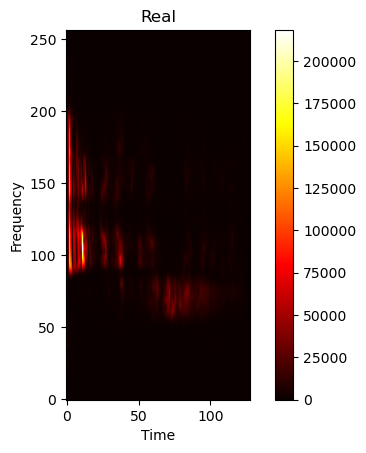

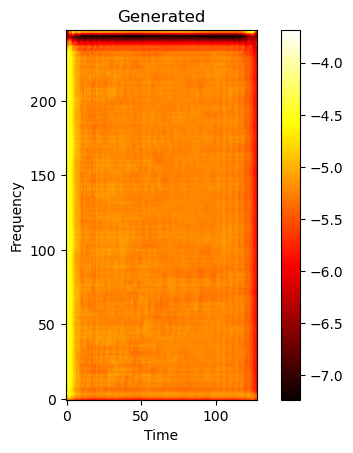

Checkpoint saved!
[0/5][50/7500]	Loss_D: 0.8264	Loss_G: 1.0846	D(x): 0.7128	D(G(z)): 0.3804 / 0.3399	Elapsed time: 00:00:38	Time left (epoch): 01:36:17	Time left (total): 08:04:00
[0/5][100/7500]	Loss_D: 0.5886	Loss_G: 1.4077	D(x): 0.7972	D(G(z)): 0.2992 / 0.2453	Elapsed time: 00:01:09	Time left (epoch): 01:26:17	Time left (total): 07:16:09
[0/5][150/7500]	Loss_D: 0.4425	Loss_G: 1.7337	D(x): 0.8133	D(G(z)): 0.2056 / 0.1789	Elapsed time: 00:01:40	Time left (epoch): 01:22:24	Time left (total): 06:58:45
[0/5][200/7500]	Loss_D: 0.3270	Loss_G: 2.2514	D(x): 0.8920	D(G(z)): 0.1799 / 0.1141	Elapsed time: 00:02:12	Time left (epoch): 01:20:21	Time left (total): 06:50:35
[0/5][250/7500]	Loss_D: 0.3556	Loss_G: 2.5955	D(x): 0.8143	D(G(z)): 0.1325 / 0.0830	Elapsed time: 00:02:43	Time left (epoch): 01:18:54	Time left (total): 06:45:23
[0/5][300/7500]	Loss_D: 0.2151	Loss_G: 2.7560	D(x): 0.8929	D(G(z)): 0.0829 / 0.0651	Elapsed time: 00:03:14	Time left (epoch): 01:17:42	Time left (total): 06:41:28
[0/5]

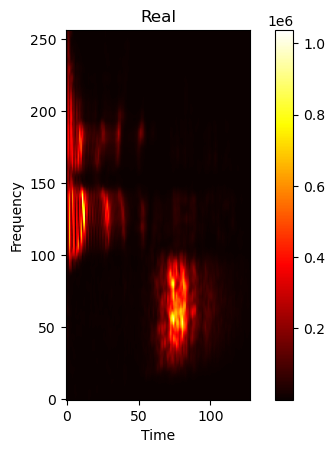

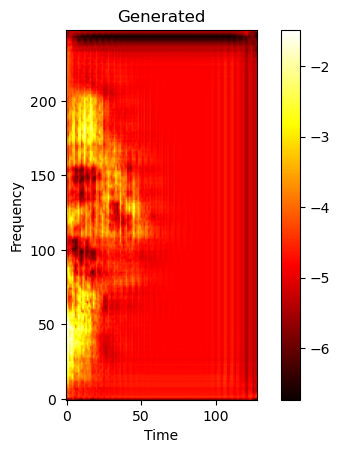

[0/5][5050/7500]	Loss_D: 0.0005	Loss_G: 7.7934	D(x): 0.9999	D(G(z)): 0.0005 / 0.0004	Elapsed time: 00:52:28	Time left (epoch): 00:25:27	Time left (total): 05:37:11
[0/5][5100/7500]	Loss_D: 0.0006	Loss_G: 7.8803	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006	Elapsed time: 00:52:59	Time left (epoch): 00:24:56	Time left (total): 05:36:39
[0/5][5150/7500]	Loss_D: 0.0024	Loss_G: 7.1589	D(x): 0.9999	D(G(z)): 0.0022 / 0.0018	Elapsed time: 00:53:30	Time left (epoch): 00:24:24	Time left (total): 05:36:06
[0/5][5200/7500]	Loss_D: 0.0008	Loss_G: 7.2667	D(x): 1.0000	D(G(z)): 0.0008 / 0.0007	Elapsed time: 00:54:01	Time left (epoch): 00:23:53	Time left (total): 05:35:34
[0/5][5250/7500]	Loss_D: 0.0034	Loss_G: 6.9926	D(x): 0.9977	D(G(z)): 0.0011 / 0.0010	Elapsed time: 00:54:32	Time left (epoch): 00:23:22	Time left (total): 05:35:01
[0/5][5300/7500]	Loss_D: 0.0780	Loss_G: 7.3661	D(x): 0.9334	D(G(z)): 0.0007 / 0.0012	Elapsed time: 00:55:03	Time left (epoch): 00:22:51	Time left (total): 05:34:30
[0/5][5350/7500]

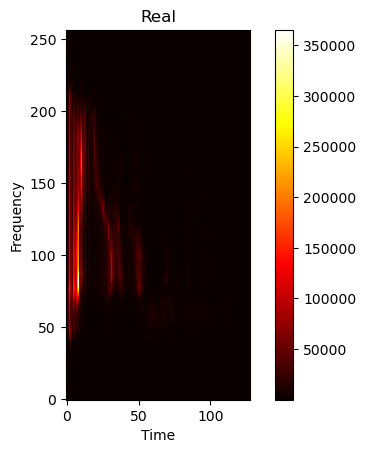

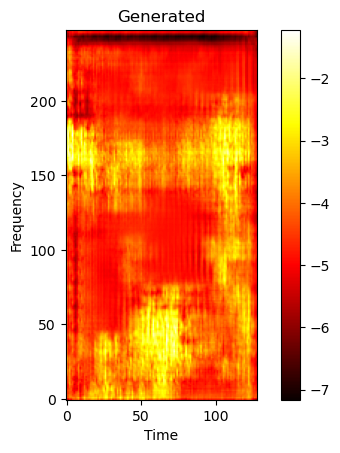

Checkpoint saved!
[1/5][50/7500]	Loss_D: 0.0010	Loss_G: 7.2268	D(x): 1.0000	D(G(z)): 0.0010 / 0.0008	Elapsed time: 01:18:29	Time left (epoch): 01:17:26	Time left (total): 05:11:21
[1/5][100/7500]	Loss_D: 0.0016	Loss_G: 7.7439	D(x): 0.9993	D(G(z)): 0.0009 / 0.0008	Elapsed time: 01:19:00	Time left (epoch): 01:16:55	Time left (total): 05:10:49
[1/5][150/7500]	Loss_D: 0.0007	Loss_G: 7.6710	D(x): 0.9998	D(G(z)): 0.0006 / 0.0005	Elapsed time: 01:19:31	Time left (epoch): 01:16:24	Time left (total): 05:10:17
[1/5][200/7500]	Loss_D: 0.0007	Loss_G: 8.1567	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004	Elapsed time: 01:20:02	Time left (epoch): 01:15:52	Time left (total): 05:09:45
[1/5][250/7500]	Loss_D: 0.0002	Loss_G: 8.7380	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002	Elapsed time: 01:20:33	Time left (epoch): 01:15:21	Time left (total): 05:09:13
[1/5][300/7500]	Loss_D: 0.0003	Loss_G: 8.6989	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002	Elapsed time: 01:21:04	Time left (epoch): 01:14:50	Time left (total): 05:08:41
[1/5]

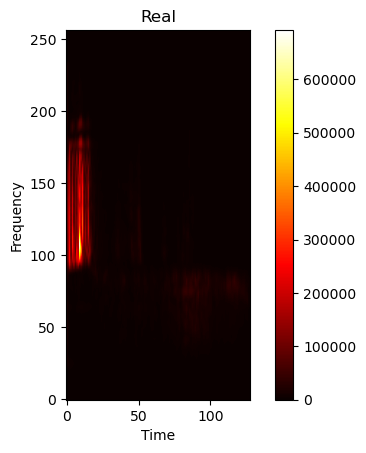

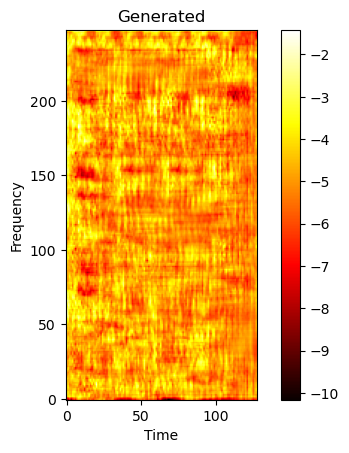

[1/5][5050/7500]	Loss_D: 0.0000	Loss_G: 10.7582	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:10:17	Time left (epoch): 00:25:26	Time left (total): 04:19:01
[1/5][5100/7500]	Loss_D: 0.0000	Loss_G: 11.4451	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:10:48	Time left (epoch): 00:24:54	Time left (total): 04:18:30
[1/5][5150/7500]	Loss_D: 0.0000	Loss_G: 12.0838	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:11:19	Time left (epoch): 00:24:23	Time left (total): 04:17:58
[1/5][5200/7500]	Loss_D: 0.0000	Loss_G: 11.8818	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:11:50	Time left (epoch): 00:23:52	Time left (total): 04:17:27
[1/5][5250/7500]	Loss_D: 0.0000	Loss_G: 11.7624	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:12:21	Time left (epoch): 00:23:21	Time left (total): 04:16:56
[1/5][5300/7500]	Loss_D: 0.0000	Loss_G: 11.4234	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:12:52	Time left (epoch): 00:22:50	Time left (total): 04:16:24
[1/5][5350

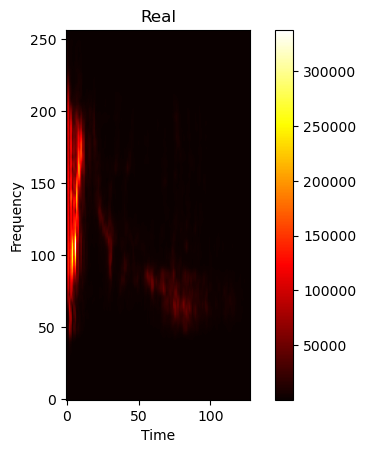

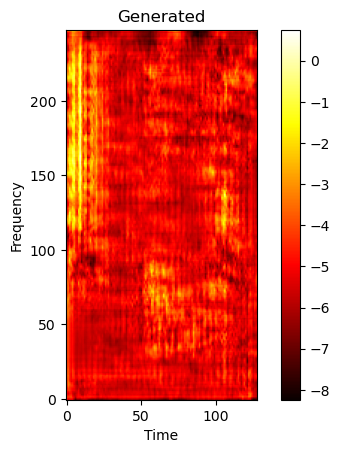

Checkpoint saved!
[2/5][50/7500]	Loss_D: 0.0000	Loss_G: 12.8501	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:36:13	Time left (epoch): 01:17:20	Time left (total): 03:53:02
[2/5][100/7500]	Loss_D: 0.0000	Loss_G: 14.0282	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:36:44	Time left (epoch): 01:16:48	Time left (total): 03:52:30
[2/5][150/7500]	Loss_D: 0.0000	Loss_G: 11.9183	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:37:15	Time left (epoch): 01:16:17	Time left (total): 03:51:59
[2/5][200/7500]	Loss_D: 0.0000	Loss_G: 13.0571	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:37:46	Time left (epoch): 01:15:46	Time left (total): 03:51:28
[2/5][250/7500]	Loss_D: 0.0000	Loss_G: 12.4769	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:38:17	Time left (epoch): 01:15:15	Time left (total): 03:50:56
[2/5][300/7500]	Loss_D: 0.0000	Loss_G: 12.8261	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 02:38:48	Time left (epoch): 01:14:43	Time left (total): 03:50:25

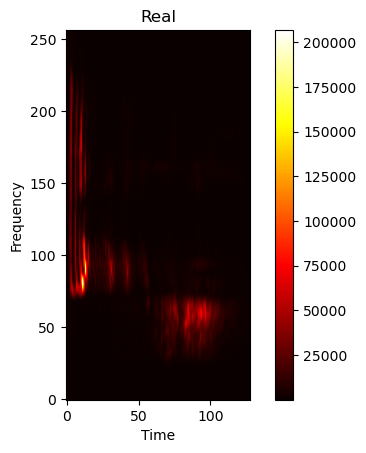

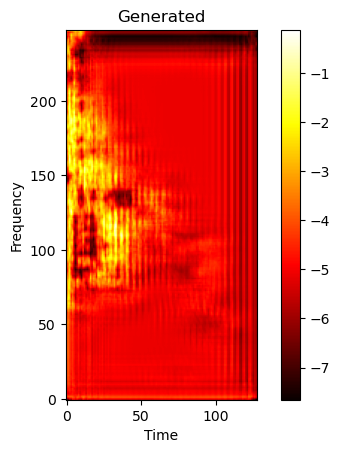

[2/5][5050/7500]	Loss_D: 0.0014	Loss_G: 7.0132	D(x): 1.0000	D(G(z)): 0.0014 / 0.0009	Elapsed time: 03:27:51	Time left (epoch): 00:25:23	Time left (total): 03:00:53
[2/5][5100/7500]	Loss_D: 0.0002	Loss_G: 11.0479	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000	Elapsed time: 03:28:22	Time left (epoch): 00:24:52	Time left (total): 03:00:22
[2/5][5150/7500]	Loss_D: 0.0015	Loss_G: 6.9235	D(x): 0.9998	D(G(z)): 0.0012 / 0.0011	Elapsed time: 03:28:53	Time left (epoch): 00:24:21	Time left (total): 02:59:51
[2/5][5200/7500]	Loss_D: 0.0016	Loss_G: 7.1270	D(x): 0.9999	D(G(z)): 0.0015 / 0.0012	Elapsed time: 03:29:24	Time left (epoch): 00:23:50	Time left (total): 02:59:20
[2/5][5250/7500]	Loss_D: 0.0005	Loss_G: 8.0502	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004	Elapsed time: 03:29:55	Time left (epoch): 00:23:19	Time left (total): 02:58:49
[2/5][5300/7500]	Loss_D: 0.0005	Loss_G: 7.8129	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004	Elapsed time: 03:30:27	Time left (epoch): 00:22:48	Time left (total): 02:58:18
[2/5][5350/7500

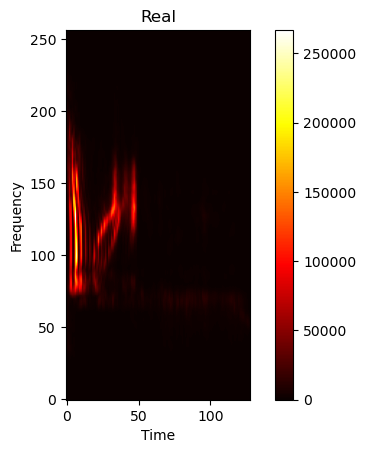

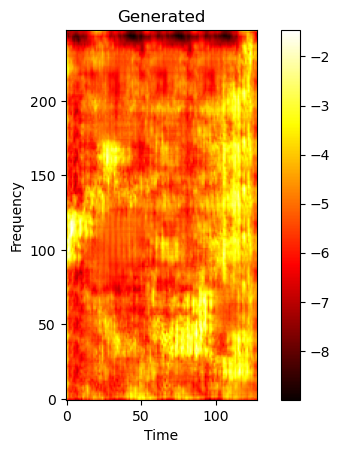

Checkpoint saved!
[3/5][50/7500]	Loss_D: 0.0000	Loss_G: 11.7847	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 03:53:45	Time left (epoch): 01:17:13	Time left (total): 02:34:58
[3/5][100/7500]	Loss_D: 0.0000	Loss_G: 10.6708	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 03:54:16	Time left (epoch): 01:16:42	Time left (total): 02:34:27
[3/5][150/7500]	Loss_D: 0.0001	Loss_G: 11.3324	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000	Elapsed time: 03:54:47	Time left (epoch): 01:16:11	Time left (total): 02:33:56
[3/5][200/7500]	Loss_D: 0.0001	Loss_G: 12.5614	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 03:55:18	Time left (epoch): 01:15:40	Time left (total): 02:33:24
[3/5][250/7500]	Loss_D: 0.0000	Loss_G: 12.1593	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 03:55:48	Time left (epoch): 01:15:09	Time left (total): 02:32:53
[3/5][300/7500]	Loss_D: 0.0001	Loss_G: 10.9655	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 03:56:19	Time left (epoch): 01:14:37	Time left (total): 02:32:22

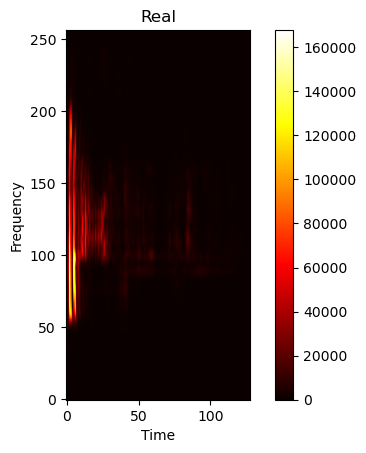

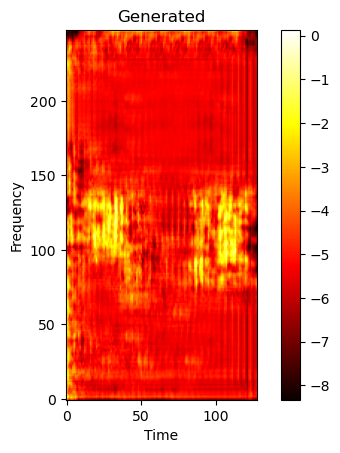

[3/5][5050/7500]	Loss_D: 0.0619	Loss_G: 5.5614	D(x): 0.9941	D(G(z)): 0.0531 / 0.0068	Elapsed time: 04:45:14	Time left (epoch): 00:25:21	Time left (total): 01:43:00
[3/5][5100/7500]	Loss_D: 0.0046	Loss_G: 6.0317	D(x): 0.9995	D(G(z)): 0.0041 / 0.0026	Elapsed time: 04:45:45	Time left (epoch): 00:24:50	Time left (total): 01:42:29
[3/5][5150/7500]	Loss_D: 0.0038	Loss_G: 6.1037	D(x): 1.0000	D(G(z)): 0.0038 / 0.0030	Elapsed time: 04:46:16	Time left (epoch): 00:24:19	Time left (total): 01:41:58
[3/5][5200/7500]	Loss_D: 0.0146	Loss_G: 5.3947	D(x): 0.9999	D(G(z)): 0.0144 / 0.0089	Elapsed time: 04:46:47	Time left (epoch): 00:23:48	Time left (total): 01:41:27
[3/5][5250/7500]	Loss_D: 0.0189	Loss_G: 5.0917	D(x): 0.9920	D(G(z)): 0.0107 / 0.0083	Elapsed time: 04:47:17	Time left (epoch): 00:23:17	Time left (total): 01:40:56
[3/5][5300/7500]	Loss_D: 0.0577	Loss_G: 6.8784	D(x): 0.9492	D(G(z)): 0.0010 / 0.0012	Elapsed time: 04:47:48	Time left (epoch): 00:22:46	Time left (total): 01:40:25
[3/5][5350/7500]

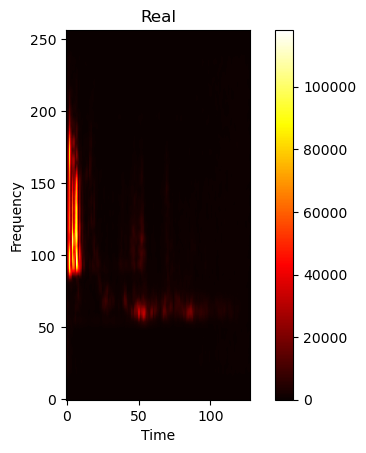

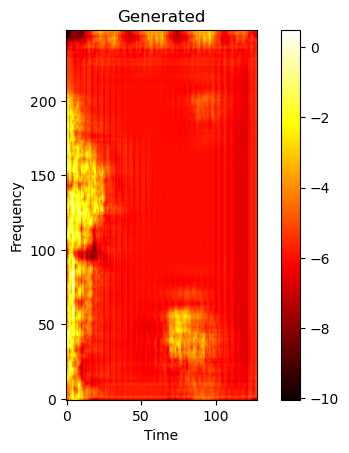

Checkpoint saved!
[4/5][50/7500]	Loss_D: 0.0002	Loss_G: 9.1940	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001	Elapsed time: 05:11:05	Time left (epoch): 01:17:07	Time left (total): 01:17:07
[4/5][100/7500]	Loss_D: 0.0006	Loss_G: 9.5888	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005	Elapsed time: 05:11:36	Time left (epoch): 01:16:36	Time left (total): 01:16:36
[4/5][150/7500]	Loss_D: 0.0005	Loss_G: 8.7987	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004	Elapsed time: 05:12:07	Time left (epoch): 01:16:05	Time left (total): 01:16:05
[4/5][200/7500]	Loss_D: 0.0135	Loss_G: 10.8513	D(x): 0.9867	D(G(z)): 0.0000 / 0.0000	Elapsed time: 05:12:38	Time left (epoch): 01:15:34	Time left (total): 01:15:34
[4/5][250/7500]	Loss_D: 0.0003	Loss_G: 8.7417	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002	Elapsed time: 05:13:09	Time left (epoch): 01:15:03	Time left (total): 01:15:03
[4/5][300/7500]	Loss_D: 0.0002	Loss_G: 11.5795	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002	Elapsed time: 05:13:40	Time left (epoch): 01:14:32	Time left (total): 01:14:32
[4/

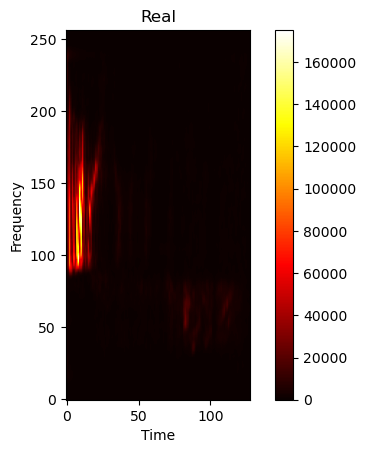

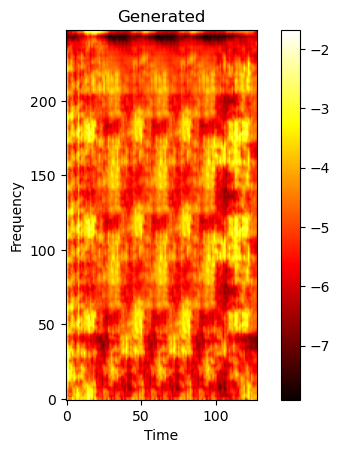

[4/5][5050/7500]	Loss_D: 0.0000	Loss_G: 11.8963	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 06:02:45	Time left (epoch): 00:25:21	Time left (total): 00:25:21
[4/5][5100/7500]	Loss_D: 0.0000	Loss_G: 12.2851	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 06:03:15	Time left (epoch): 00:24:50	Time left (total): 00:24:50
[4/5][5150/7500]	Loss_D: 0.0000	Loss_G: 12.4810	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 06:03:46	Time left (epoch): 00:24:19	Time left (total): 00:24:19
[4/5][5200/7500]	Loss_D: 0.0000	Loss_G: 12.0824	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 06:04:17	Time left (epoch): 00:23:48	Time left (total): 00:23:48
[4/5][5250/7500]	Loss_D: 0.0000	Loss_G: 12.6317	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 06:04:47	Time left (epoch): 00:23:17	Time left (total): 00:23:17
[4/5][5300/7500]	Loss_D: 0.0000	Loss_G: 12.5112	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000	Elapsed time: 06:05:18	Time left (epoch): 00:22:46	Time left (total): 00:22:46
[4/5][5350

In [41]:
# Training Loop

# Load checkpoint if it exists
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH)

    # Set variables
    netG.load_state_dict(checkpoint['generator_state_dict'])
    netD.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizerG.load_state_dict(checkpoint['generator_optimizer_state_dict'])
    optimizerD.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])
    epoch = checkpoint['epoch']
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    img_list = checkpoint['img_list']
    iters = checkpoint['iters']

    print("Loaded checkpoint from epoch", epoch)
else:
    print("No checkpoint found, starting from scratch.")
    # Set variables to initial values
    G_losses = []
    D_losses = []
    img_list = []
    iters = 0
    epoch = 0
    netG.apply(weights_init)
    netD.apply(weights_init)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
start_time = time.time()
# For each epoch
for epoch in range(epoch, num_epochs):
    epoch_start_time = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        real = vae.encode(real_cpu).latent_dist.mode()
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake latent features batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i > 0 and i % 50 == 0:
            elapsed_time = time.time() - start_time
            avg_time_per_batch = elapsed_time / (i + epoch * len(dataloader))     
            remaining_time_epoch = avg_time_per_batch * (len(dataloader) - i)
            remaining_time_total = avg_time_per_batch * (len(dataloader) * (num_epochs - epoch) - i)          
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tElapsed time: %s\tTime left (epoch): %s\tTime left (total): %s'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,
                     format_time(elapsed_time), format_time(remaining_time_epoch), format_time(remaining_time_total)))

        if i % 5000 == 0:
            # Generate a spectrogram and display it
            dec = vae.decode(fake).sample
            show_spectrogram(real_cpu.detach().cpu()[0, 0,:,:], "Real")
            show_spectrogram(dec.detach().cpu()[0, 0, :, :], "Generated")

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        # Save checkpoint
        if i % CHECKPOINT_INTERVAL == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': netG.state_dict(),
                'discriminator_state_dict': netD.state_dict(),
                'generator_optimizer_state_dict': optimizerG.state_dict(),
                'discriminator_optimizer_state_dict': optimizerD.state_dict(),
                'G_losses': G_losses,
                'D_losses': D_losses,
                'img_list': img_list,
                'iters': iters
            }, CHECKPOINT_PATH)
            print("Checkpoint saved!")
            
    epoch_elapsed_time = time.time() - epoch_start_time
    print("Time elapsed for epoch", epoch, ":", format_time(epoch_elapsed_time))

print("Training finished!")

In [43]:
import csv

# Save G_losses to CSV
with open('G_losses.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(G_losses)

# Save D_losses to CSV
with open('D_losses.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(D_losses)

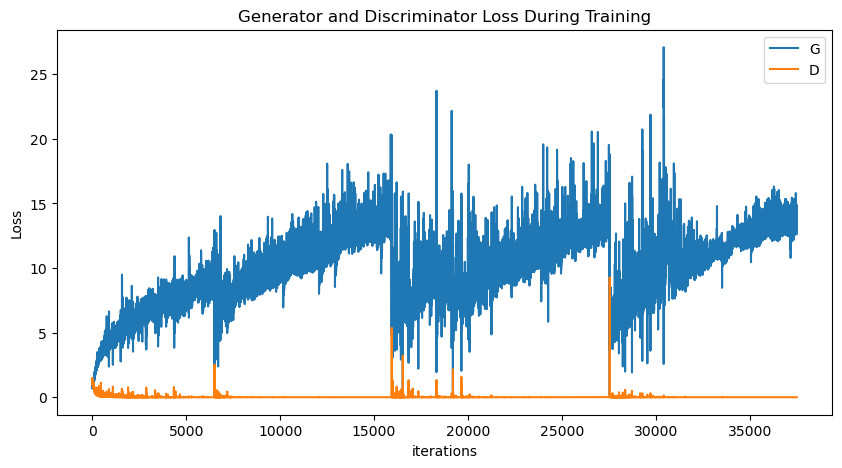

In [44]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()